In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pycaret.time_series import TSForecastingExperiment
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots
from datetime import datetime
import sys
from pathlib import Path

# Add project root to path (assuming notebook is in the notebooks directory)
project_root = Path().absolute().parent
sys.path.append(str(project_root))

# Local imports
from src.core.bloomberg_fetcher import fetch_bloomberg_data
from src import trans_utils  # Using the one from src root since that's what you have open
from src.utils import merge_utils  # Using the one from utils since that's what you have open
from src.utils.csv_exporter import export_to_csv

In [2]:
# Getting all the data 
mapping = {
    ('I05510CA Index', 'INDEX_OAS_TSY_BP'): 'cad_oas',
    ('LF98TRUU Index', 'INDEX_OAS_TSY_BP'): 'us_hy_oas',
    ('LUACTRUU Index', 'INDEX_OAS_TSY_BP'): 'us_ig_oas',
    ('SPTSX Index', 'PX_LAST'): 'tsx',
    ('VIX Index', 'PX_LAST'): 'vix',
    ('USYC3M30 Index', 'PX_LAST'): 'us_3m_10y',
    ('BCMPUSGR Index', 'PX_LAST'): 'us_growth_surprises',
    ('BCMPUSIF Index', 'PX_LAST'): 'us_inflation_surprises',
    ('LEI YOY  Index', 'PX_LAST'): 'us_lei_yoy',
    ('.HARDATA G Index', 'PX_LAST'): 'us_hard_data_surprises',
    ('CGERGLOB Index', 'PX_LAST'): 'us_equity_revisions',
    ('.ECONREGI G Index', 'PX_LAST'): 'us_economic_regime',
 
}

# Calculate dates
end_date = datetime.now().strftime('%Y-%m-%d')
start_date ='2002-01-01'

# Fetch the data
df = fetch_bloomberg_data(
    mapping=mapping,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Getting all the er_ytd data 
mapping1 = {
    ('I05510CA Index', 'INDEX_EXCESS_RETURN_YTD'): 'cad_ig_er',
    ('LF98TRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_hy_er',
    ('LUACTRUU Index', 'INDEX_EXCESS_RETURN_YTD'): 'us_ig_er',
}

# Fetch the er_ytd_data
df1 = fetch_bloomberg_data(
    mapping=mapping1,
    start_date=start_date,
    end_date=end_date,
    periodicity='M',
    align_start=True
).dropna()

# Conver er_ytd data to an index
df2= trans_utils.convert_er_ytd_to_index(df1[['cad_ig_er','us_hy_er','us_ig_er']])
final_df=merge_utils.merge_dfs(df, df2, fill='ffill', start_date_align='yes')

# Handle bad data point for cad_oas on Nov 15 2005
bad_date = '2005-11-15'
if bad_date in final_df.index:
    final_df.loc[bad_date, 'cad_oas'] = final_df.loc[final_df.index < bad_date, 'cad_oas'].iloc[-1]


#  Fill the first row with 100 (starting index value)
final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']] = final_df[['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index']].fillna(100)
# Drop the er_index columns
final_df = final_df.drop(['cad_ig_er_index', 'us_hy_er_index', 'us_ig_er_index'], axis=1)


# Calculate TSX percent changes for different periods
final_df['tsx_1m'] = final_df['tsx'].pct_change(periods=1) * 100
final_df['tsx_3m'] = final_df['tsx'].pct_change(periods=3) * 100
final_df['tsx_6m'] = final_df['tsx'].pct_change(periods=6) * 100
final_df['tsx_12m'] = final_df['tsx'].pct_change(periods=12) * 100

# Drop the original tsx column
final_df = final_df.drop('tsx', axis=1)

# Drop any NA rows that resulted from the calculations
final_df = final_df.dropna()

# Export the final DataFrame to CSV, overwriting if exists
export_path = export_to_csv(
    data=final_df,
    name='monthly_oas_pycaret',
    export_dir='c:/Users/Eddy/Documents/auto_ml/csv_outputs',
    overwrite=True  # Explicitly set to overwrite existing file
)

print(final_df.info())
print('-----------------------------')
print('-----------------------------')
print(final_df.head())
print('-----------------------------')
print('-----------------------------')
print(final_df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 2003-08-29 to 2024-12-31
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cad_oas                 331 non-null    float64
 1   us_hy_oas               331 non-null    float64
 2   us_ig_oas               331 non-null    float64
 3   vix                     331 non-null    float64
 4   us_3m_10y               331 non-null    float64
 5   us_growth_surprises     331 non-null    float64
 6   us_inflation_surprises  331 non-null    float64
 7   us_lei_yoy              331 non-null    float64
 8   us_hard_data_surprises  331 non-null    float64
 9   us_equity_revisions     331 non-null    float64
 10  us_economic_regime      331 non-null    float64
 11  tsx_1m                  331 non-null    float64
 12  tsx_3m                  331 non-null    float64
 13  tsx_6m                  331 non-null    float64
 14  tsx_12m                

,Description,Value
0,Session id,123
1,Target,next_period_target
2,Target type,Regression
3,Original data shape,"(256, 15)"
4,Transformed data shape,"(256, 15)"
5,Transformed train set shape,"(179, 15)"
6,Transformed test set shape,"(77, 15)"
7,Ignore features,1
8,Numeric features,14
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lar,Least Angle Regression,24.2639,1157.7554,31.0632,0.2177,0.2129,0.1611,0.0067
huber,Huber Regressor,24.8055,880.3245,29.2158,-0.4090,0.2357,0.1846,0.0133
ridge,Ridge Regression,29.1888,1733.4169,35.1303,0.2251,0.2407,0.1883,0.0067
lasso,Lasso Regression,28.5184,1333.6697,33.1952,0.1303,0.2348,0.1913,0.0133
llar,Lasso Least Angle Regression,28.5179,1333.5855,33.1946,0.1303,0.2348,0.1913,0.0067
en,Elastic Net,28.7515,1368.7896,33.4906,0.1281,0.2360,0.1923,0.0067
lr,Linear Regression,32.9641,2686.3304,41.1194,0.0849,0.2762,0.2037,0.0067
par,Passive Aggressive Regressor,28.0455,984.3016,30.6547,-0.5786,0.2695,0.2132,0.0100
br,Bayesian Ridge,33.1821,1905.8671,38.3192,-0.0294,0.2676,0.2177,0.0067
dummy,Dummy Regressor,48.8286,6485.2601,60.6494,-0.7726,0.4527,0.2829,0.0100



Model Summary:
Lars(random_state=123)

=== Generating residuals plot ===


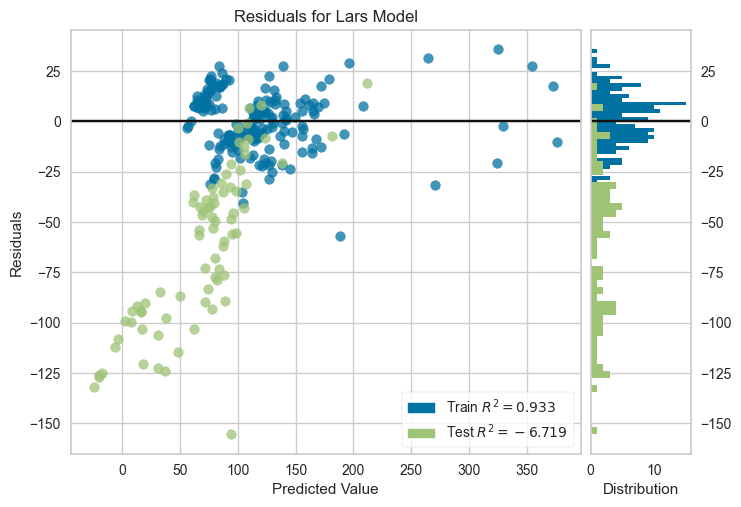




=== Generating error plot ===


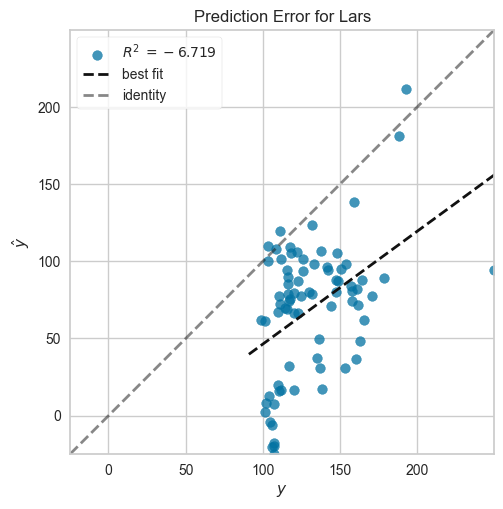




=== Generating cooks plot ===


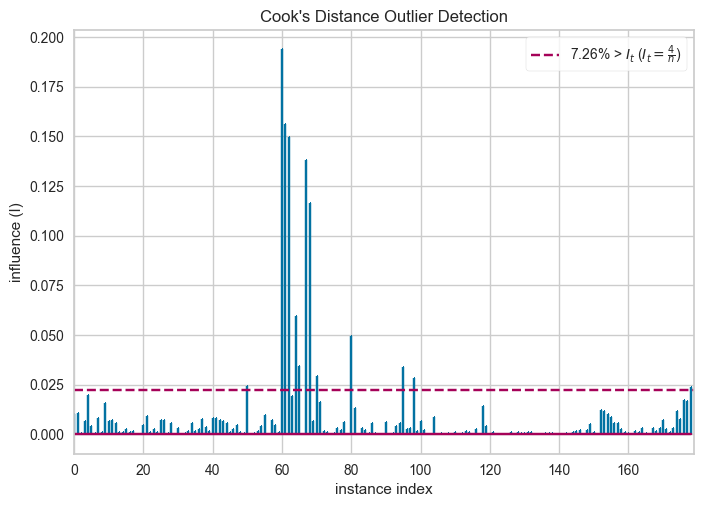




=== Generating rfe plot ===


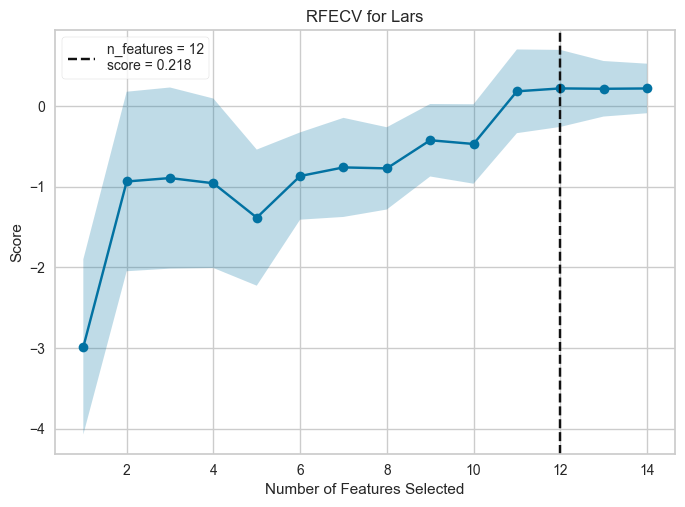




=== Generating learning plot ===


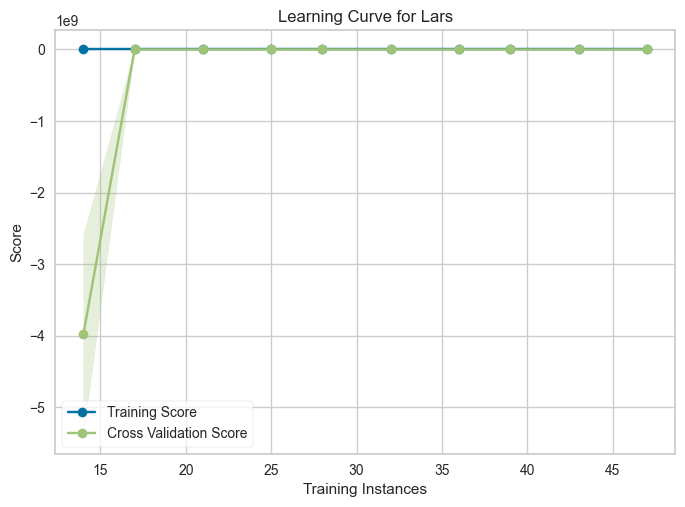




=== Generating vc plot ===


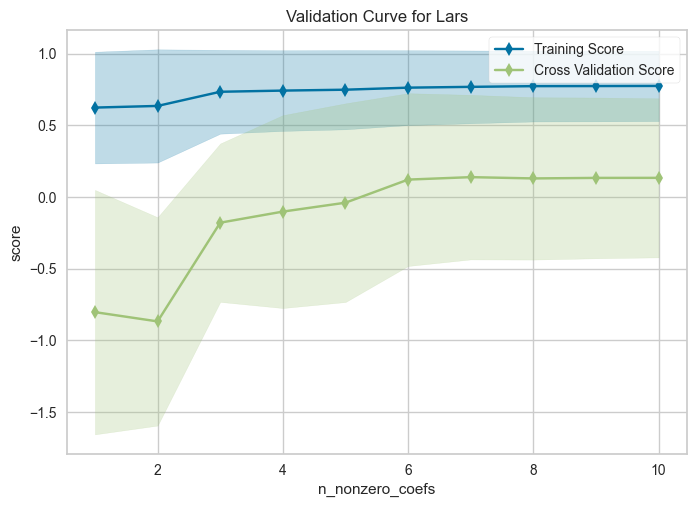




=== Generating manifold plot ===


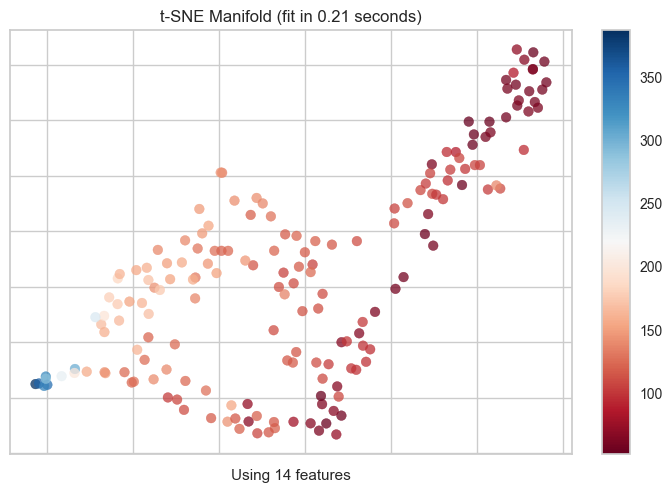




=== Generating feature plot ===


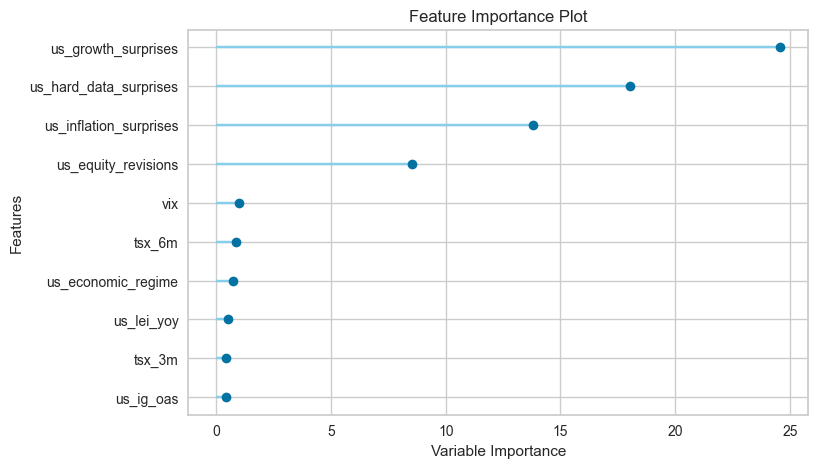




=== Generating feature_all plot ===


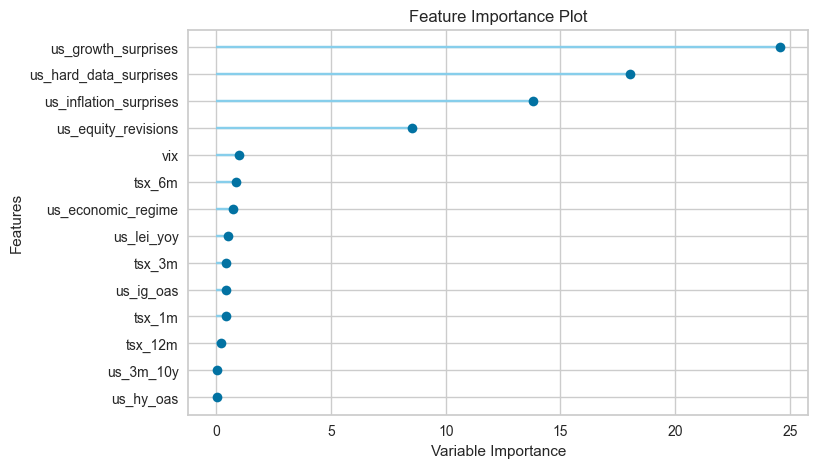




=== Generating parameter plot ===


,Parameters
copy_X,True
eps,2.220446049250313e-16
fit_intercept,True
fit_path,True
jitter,None
n_nonzero_coefs,500
precompute,auto
random_state,123
verbose,False





=== Generating tree plot ===
Could not generate tree plot: Decision Tree plot is only available for scikit-learn Decision Trees and Forests, Ensemble models using those or Stacked models using those as meta (final) estimators.





Next Period Prediction: 94.66


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,14.2761,348.9482,18.6802,0.8633,0.1768,0.1388


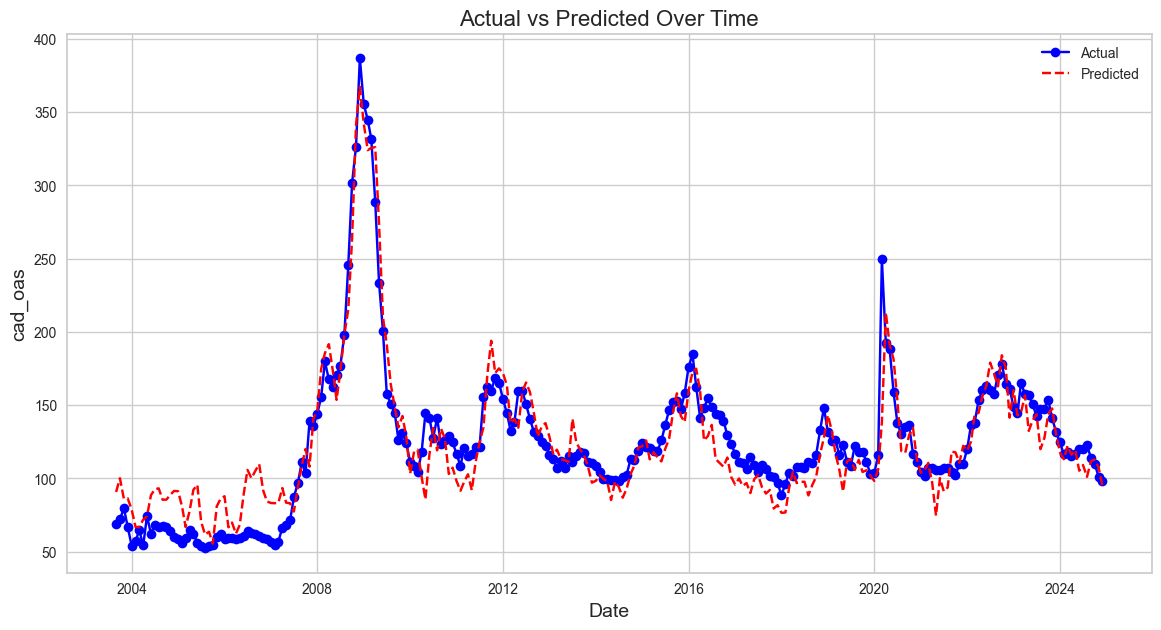

Transformation Pipeline and Model Successfully Saved
Model saved to best_regression_model.pkl

SHAP Explanation:
SHAP explanation failed: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['us_hy_oas', 'us_ig_oas', 'vix',
                                             'us_3m_10y', 'us_growth_surprises',
                                             'us_inflation_surprises',
                                             'us_lei_yoy',
                                             'us_hard_data_surprises',
                                             'us_equity_revisions',
                                             'us_economic_regime', 'tsx_1m',
                                             'tsx_3m', 'tsx_6m', 'tsx_12m'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
 

In [7]:
import pandas as pd
from pycaret.regression import *
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

def prepare_forecasting_data(data, target_col):
    """Prepare data for next period prediction without lagged features"""
    df = data.copy()
    
    # Shift the target variable to create the next period's value
    df['next_period_target'] = df[target_col].shift(-1)
    
    # Drop rows with NaN values (created by shifting the target)
    df = df.dropna()
    
    # Drop the original target column to avoid using it as a feature
    df = df.drop(columns=[target_col])
    
    return df

def train_predict_model(data):
    """Train regression model and analyze results"""
    # Setup regression experiment
    s = setup(
        data=data,
        target='next_period_target',  # Predict the next period's value
        fold_strategy='timeseries',
        fold=3,
        data_split_shuffle=False,
        fold_shuffle=False,
        session_id=123,
        verbose=True,  # Enable verbose output
        ignore_features=['cad_oas']  # Explicitly ignore 'cad_oas'
    )
    
    # Compare regression models
    best_model = compare_models(sort='MAPE')
    
    # Analyze model
    print("\nModel Summary:")
    print(best_model)
    
    # Generate all possible PyCaret visualizations
    plot_types = [
        'residuals',        # Residuals plot
        'error',            # Prediction Error
        'cooks',            # Cook's Distance
        'rfe',              # Feature Selection
        'learning',         # Learning Curve
        'vc',               # Validation Curve
        'manifold',         # Manifold Learning
        'feature',          # Feature Importance
        'feature_all',      # Feature Importance (All)
        'parameter',        # Model Hyperparameters
        'tree',             # Decision Tree (if tree-based)
    ]
    
    for plot_type in plot_types:
        try:
            print(f"\n=== Generating {plot_type} plot ===")
            plot_model(best_model, plot=plot_type)  # Remove display_format
            plt.show()
        except Exception as e:
            print(f"Could not generate {plot_type} plot: {str(e)}")
        print("\n" + "=" * 80 + "\n")
    
    # Finalize model
    final_model = finalize_model(best_model)
    return final_model

def make_predictions(model, data):
    """Make predictions using trained model"""
    # Prepare most recent data for prediction
    latest_data = data.tail(1).drop('next_period_target', axis=1)
    
    # Generate prediction
    prediction = predict_model(model, data=latest_data)
    print(f"\nNext Period Prediction: {prediction['prediction_label'].values[0]:.2f}")
    
    return prediction

def plot_actual_vs_predicted(data, model):
    """Plot actual vs predicted values over time"""
    # Make predictions on the entire dataset
    predictions = predict_model(model, data=data)
    data['Predicted'] = predictions['prediction_label']
    
    # Plot actual vs predicted over time
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['next_period_target'], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(data.index, data['Predicted'], label='Predicted', marker='x', linestyle='--', color='red')
    plt.title('Actual vs Predicted Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('cad_oas', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
file_path = 'c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv'

# Load and prepare data
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.sort_index().asfreq('M').ffill()

# Prepare data for next period prediction
data = prepare_forecasting_data(data, target_col='cad_oas')

# Train model
model = train_predict_model(data)

# Make predictions
prediction = make_predictions(model, data)

# Plot actual vs predicted over time
plot_actual_vs_predicted(data, model)

# Save model
model_save_path = Path('best_regression_model')
save_model(model, model_save_path)
print(f"Model saved to {model_save_path}.pkl")

# SHAP explainability
try:
    print("\nSHAP Explanation:")
    explainer = shap.Explainer(model)
    shap_values = explainer(data.drop('next_period_target', axis=1))
    shap.plots.waterfall(shap_values[0])
except Exception as e:
    print(f"SHAP explanation failed: {e}")

In [ ]:
import pandas as pd
from pycaret.time_series import *
import shap  # For SHAP-based feature analysis

def load_and_prepare_data(file_path):
    """
    Load and prepare the data for time series modeling
    """
    df = pd.read_csv(file_path)
    
    # Check if 'cad_oas' column exists
    if 'cad_oas' not in df.columns:
        raise ValueError("Column 'cad_oas' not found in the dataset. Please check the dataset.")
    
    # Convert Date column to datetime and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Sort index to ensure chronological order
    df = df.sort_index()
    
    # Ensure monthly frequency and forward fill any missing values
    df = df.asfreq('M', method='ffill')
    
    return df

def train_predict_model(data):
    """
    Train a time series model using ONLY exogenous features
    """
    # Debug: Check if 'cad_oas' exists in the data
    if 'cad_oas' not in data.columns:
        raise ValueError("Column 'cad_oas' not found in the dataset. Available columns: " + str(data.columns))
    
    # Initialize PyCaret time series setup
    s = setup(
        data=data,
        target='cad_oas',
        fh=1,  # Forecast 1 step ahead
        fold=3,
        seasonal_period=12,
        fold_strategy='expanding',
        transform_target=None,
        session_id=123,
        ignore_features=['cad_oas'],  # Explicitly exclude target from features
        enforce_exogenous=True,  # Force model to use only specified exogenous features
        numeric_imputation_target='ffill',  # Handle target gaps if needed
        numeric_imputation_exogenous='ffill'  # Handle feature gaps if needed
    )
    
    # Compare models that support exogenous variables
    best_model = compare_models(sort='MAPE', include=['lr', 'dt', 'rf', 'xgboost', 'lightgbm'])
    
    # Get model performance metrics
    model_metrics = pull()
    
    # Generate diagnostic plots
    plot_types = [
        'ts',              # Time Series Plot
        'cv',              # Cross Validation
        'diagnostics',     # Model Diagnostics
        'residuals',       # Residuals Plot
        'forecast',        # Forecast Plot
    ]
    
    print("\n=== Generating Diagnostic Plots ===")
    for plot_type in plot_types:
        try:
            print(f"\nGenerating {plot_type} plot...")
            plot_model(best_model, plot=plot_type)
            plt.show()
        except Exception as e:
            print(f"Could not generate {plot_type} plot: {str(e)}")
        print("\n" + "=" * 80 + "\n")
    
    # Finalize the best model
    final_model = finalize_model(best_model)
    
    # Confirm features used by the model
    print("\nFeatures Used by the Model:")
    print(final_model.exogenous_variables)
    
    return final_model, model_metrics

def analyze_model_performance(model, data):
    """
    Analyze model performance metrics and make predictions
    """
    # Get performance metrics
    metrics = pull()
    print("\nModel Performance Metrics:")
    print(metrics)
    
    # Get exogenous variables for prediction
    exog_data = data.drop('cad_oas', axis=1).iloc[-1:].copy()
    
    # Make predictions
    predictions = predict_model(model, X=exog_data)
    
    # Get last actual and predicted values
    last_actual = data['cad_oas'].iloc[-1]
    pred_col = predictions.columns[-1]  # Prediction column is the last one
    next_pred = predictions[pred_col].iloc[-1]
    
    print("\nPrediction Results:")
    print(f"Last actual value: {last_actual:.4f}")
    print(f"Predicted next value: {next_pred:.4f}")

def explain_model_with_shap(model, data):
    """
    Explain model predictions using SHAP values (for tree-based models)
    """
    try:
        print("\nSHAP-based Feature Explanation:")
        # Create a SHAP explainer
        explainer = shap.TreeExplainer(model)
        
        # Get SHAP values
        shap_values = explainer.shap_values(data.drop('cad_oas', axis=1))
        
        # Plot SHAP summary
        shap.summary_plot(shap_values, data.drop('cad_oas', axis=1))
    except Exception as e:
        print(f"SHAP explanation not supported for this model: {e}")

# Main execution
file_path = 'c:/Users/Eddy/Documents/auto_ml/csv_outputs/monthly_oas_pycaret.csv'

# Load and prepare data
data = load_and_prepare_data(file_path)

# Train model and get predictions
model, metrics = train_predict_model(data)

# Analyze model performance
analyze_model_performance(model, data)

# Explain model using SHAP (if applicable)
explain_model_with_shap(model, data)

# Save the model in the current directory
model_save_name = 'best_time_series_model'  # Name of the model file
save_model(model, model_save_name)
print(f"\nModel saved to {model_save_name}.pkl in the current directory.")

KeyError: 'cad_oas'